### Loading In The Dataset

In [1]:
import tensorflow as tf 
import matplotlib as plt
import numpy as np
import matplotlib.image as mpimg
from LOAD_DATA import get_IDs, get_image_data

#Train Images
tsv_p_train= "DATA/stimulus_perceptionNaturalImageTraining.tsv"
Path_to_train="DATA/Images_InTrainSet/"
Train_CLASS_ID, Train_IMAGE_ID = get_IDs(tsv_p_train)    
Train_images= get_image_data(Path_to_train, Train_IMAGE_ID, dim=(32,32))
print(Train_images.shape)


#Test Images
tsv_p_test= "DATA/stimulus_perceptionNaturalImageTest.tsv"
Path_to_test= "DATA/Images_InTestSet/"
Test_CLASS_ID, Test_IMAGE_ID = get_IDs(tsv_p_test)    
Test_images= get_image_data(Path_to_test, Test_IMAGE_ID, dim=(32,32))
print(Test_images.shape)

#load fMRI embeddings
fMRIembedding_Train = np.load('DATA/fMRI512embeddingsTrain.npy')
fMRIembedding_Test  = np.load("DATA/fMRI512embeddingsTest.npy")

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

(1200, 32, 32, 3)
(50, 32, 32, 3)


In [2]:
def Image_Process_Train(x):
    out=x
    for io in range(4):
        out=tf.concat([out, x], axis=0)
    out=out/255
    return out 

def Image_Process_Test(x):
    out=x
    for io in range(23):
        out=tf.concat([out, x], axis=0)

    out=out/255
    return out    

X0=Image_Process_Train(Train_images)
X1=Image_Process_Test(Test_images)


L0 = fMRIembedding_Train *100
L1 = fMRIembedding_Test  *100

In [3]:
from MODEL import CVAE


latent_dim=32
model = CVAE( 
    
    encoder = tf.keras.Sequential(
            [
                tf.keras.layers.Conv2D(filters=256, kernel_size=3, strides=(2, 2), activation=tf.keras.layers.LeakyReLU(alpha=0.2), padding='same'), #input_shape=(32, 32, 3)),
                tf.keras.layers.Conv2D(filters=128, kernel_size=3, strides=(2, 2), activation=tf.keras.layers.LeakyReLU(alpha=0.1), padding='same'),               
                tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=(2, 2), activation=tf.keras.layers.LeakyReLU(alpha=0.1), padding='same'),
        
                tf.keras.layers.Flatten(),
                tf.keras.layers.Dense(latent_dim + latent_dim, )
            ], name='encoder'

        ),
    decoder = tf.keras.Sequential(
            [
                tf.keras.layers.Dense(units=8*8*32, activation=tf.keras.layers.LeakyReLU(alpha=0.2)),
                
                tf.keras.layers.Reshape(target_shape=(8, 8, 32)),
                tf.keras.layers.Conv2DTranspose(filters=512, kernel_size=3, strides=2, padding='same', activation='sigmoid'),
                tf.keras.layers.Conv2DTranspose(filters=256, kernel_size=3, strides=2, padding='same', activation='sigmoid'),
                #tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding='same', activation='sigmoid'),
                tf.keras.layers.Conv2DTranspose(filters=3, kernel_size=3, strides=1, padding='same' , activation = 'sigmoid'),
            ],
             name='encoder'
        ),


   latent_dim = latent_dim
    
)

model((X0[:5], L0[:5]))
model.summary()
model.encoder.summary()
model.decoder.summary()


Model: "cvae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Sequential)        (5, 64)                   441600    
                                                                 
 encoder (Sequential)        (5, 32, 32, 3)            2450947   
                                                                 
Total params: 2,892,551
Trainable params: 2,892,547
Non-trainable params: 4
_________________________________________________________________
Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (5, 16, 16, 256)          7168      
                                                                 
 conv2d_1 (Conv2D)           (5, 8, 8, 128)            295040    
                                                                 
 conv2d_2 (Conv2D)           (5, 4,

In [4]:
def kld_loss(z_log_var, z_mean):
    kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
    kl_loss = tf.reduce_mean(kl_loss, axis=1)
    return kl_loss

def rec_loss(data, recon):
    recon_loss = tf.keras.losses.mean_squared_error(data, recon)
    recon_loss = tf.reduce_sum(recon_loss, axis=(1,2))
    return recon_loss



model.compile( optimizer = tf.keras.optimizers.Adam(1), **{'kld_loss':kld_loss, 'rec_loss':rec_loss} )  


model.fit(
    
    (X0, L0), X0,
    epochs     = 50,
    batch_size = 1000,
    )


Epoch 1/50


2022-12-10 12:15:54.781771: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


6/6 [==============================] - 10s 2s/step - kld_loss: 0.0083 - recon_loss: 237.8635
Epoch 2/50
6/6 [==============================] - 9s 2s/step - kld_loss: 0.0388 - recon_loss: 155.4728
Epoch 3/50
6/6 [==============================] - 9s 2s/step - kld_loss: 7.1797e-04 - recon_loss: 119.2077
Epoch 4/50
6/6 [==============================] - 9s 2s/step - kld_loss: 5.4482e-04 - recon_loss: 101.5004
Epoch 5/50
6/6 [==============================] - 9s 2s/step - kld_loss: 4.1536e-04 - recon_loss: 99.6432
Epoch 6/50
6/6 [==============================] - 9s 2s/step - kld_loss: 3.5223e-04 - recon_loss: 107.3221
Epoch 7/50
6/6 [==============================] - 9s 2s/step - kld_loss: 4.0529e-04 - recon_loss: 93.7762
Epoch 8/50
6/6 [==============================] - 9s 2s/step - kld_loss: 0.0013 - recon_loss: 93.8851
Epoch 9/50
6/6 [==============================] - 9s 2s/step - kld_loss: 0.0064 - recon_loss: 92.3157
Epoch 10/50
6/6 [==============================] - 9s 2s/step - kld

In [5]:
# model.save_weights('Model1/Checkpoint1')
# load_status = model.load_weights("Model1/Checkpoint1")
# load_status.assert_consumed()

model.compile( optimizer = tf.keras.optimizers.Adam(0.01), **{'kld_loss':kld_loss, 'rec_loss':rec_loss} )  
model.fit(
    
    (X0, L0), X0,
    epochs     = 1000,
    batch_size = 1000,
    )


Epoch 1/1000
6/6 [==============================] - 10s 2s/step - kld_loss: 3.2805 - recon_loss: 86.8597
Epoch 2/1000
6/6 [==============================] - 9s 2s/step - kld_loss: 2.5324 - recon_loss: 50.0108
Epoch 3/1000
6/6 [==============================] - 9s 2s/step - kld_loss: 2.3764 - recon_loss: 45.3057
Epoch 4/1000
6/6 [==============================] - 9s 2s/step - kld_loss: 2.1541 - recon_loss: 50.5900
Epoch 5/1000
6/6 [==============================] - 9s 2s/step - kld_loss: 2.2283 - recon_loss: 47.6839
Epoch 6/1000
6/6 [==============================] - 9s 2s/step - kld_loss: 2.0491 - recon_loss: 46.9681
Epoch 7/1000
6/6 [==============================] - 9s 2s/step - kld_loss: 2.0609 - recon_loss: 45.9908
Epoch 8/1000
6/6 [==============================] - 9s 2s/step - kld_loss: 2.1492 - recon_loss: 46.4595
Epoch 9/1000
6/6 [==============================] - 9s 2s/step - kld_loss: 2.0952 - recon_loss: 45.9167
Epoch 10/1000
6/6 [==============================] - 9s 2s/step

In [18]:
model.fit(    
    (X0, L0), X0,
    epochs     = 100,
    batch_size = 1000
    )


Epoch 1/100
6/6 [==============================] - 20s 2s/step - kld_loss: 2.2242 - recon_loss: 16.3749
Epoch 2/100
6/6 [==============================] - 9s 2s/step - kld_loss: 2.2179 - recon_loss: 16.8368
Epoch 3/100
6/6 [==============================] - 9s 2s/step - kld_loss: 2.2222 - recon_loss: 16.4676
Epoch 4/100
6/6 [==============================] - 9s 2s/step - kld_loss: 2.2447 - recon_loss: 16.5800
Epoch 5/100
6/6 [==============================] - 9s 2s/step - kld_loss: 2.2913 - recon_loss: 16.8173
Epoch 6/100
6/6 [==============================] - 9s 2s/step - kld_loss: 2.2535 - recon_loss: 16.4402
Epoch 7/100
6/6 [==============================] - 9s 2s/step - kld_loss: 2.2206 - recon_loss: 16.6136
Epoch 8/100
6/6 [==============================] - 10s 2s/step - kld_loss: 2.2334 - recon_loss: 16.3862
Epoch 9/100
6/6 [==============================] - 10s 2s/step - kld_loss: 2.2991 - recon_loss: 16.9493
Epoch 10/100
6/6 [==============================] - 9s 2s/step - kld_l

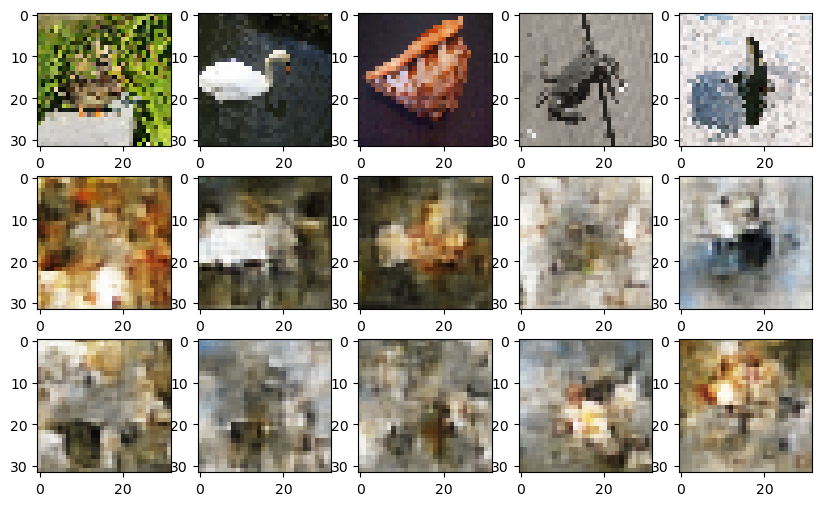

In [55]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows=3, ncols=5, figsize=(10, 6))

STT=3

ESS=STT+5
x  = X1[STT:ESS]
L_C= L1[STT:ESS]

xp=model.encoder(x)
m, v, zp = model.latent_ops(xp)
z_cat = tf.concat([zp, L_C], axis=-1)
z_noise_cat= tf.concat([np.random.normal( size=( 5,latent_dim)), L_C], axis=-1)

y = model.decoder(z_cat)
y_noise = model.decoder(z_noise_cat)




for i in range(5):
    axs[0][i].imshow(x[i,:,:,:])
    axs[1][i].imshow(y[i,:,:,:])
    axs[2][i].imshow(y_noise[i,:,:,:])
